# VAE
Let's check if we can use the pretrained AutoencoderKL to reduce the image size without loosing quality

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from diffusers import AutoencoderKL

import torch
import torchvision.transforms as T

from torch_moving_mnist.utils import *

# mpl.rcParams['image.cmap'] = 'gray_r'

NOTE: Redirects are currently not supported in Windows or MacOs.


In [ ]:
device = "mps"

In [ ]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)

In [ ]:
data = np.load("B07_2022_06_04.npy")
data.shape

(96, 1, 446, 780)

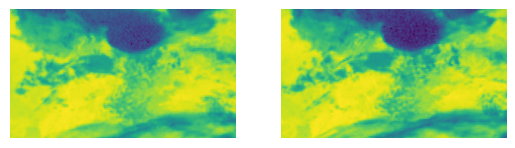

In [ ]:
show_images(data[10:12].squeeze(), nrows=1)

In [ ]:
tdata = torch.from_numpy(data).to(device)

In [ ]:
to_rgb = T.Lambda(lambda x: x.repeat(1, 3, 1, 1) if x.size(1)==1 else x)

In [ ]:
rgb_data = to_rgb(tdata)

In [ ]:
def scale(arr):
    "Scales values of array in [0,1]"
    m, M = arr.min(), arr.max()
    return (arr - m) / (M - m)

In [ ]:
rgb_data = scale(rgb_data)

one image

In [ ]:
img = rgb_data[12]

In [ ]:
def describe(img):
    print(  f"Image of type: {type(img)}\n"
            f"data type:     {img.dtype}\n"
            f"shape:         {img.shape}\n"
            f"min:           {img.min()}\n"
            f"max:           {img.max()}\n")

In [ ]:
describe(img)

Image of type: <class 'torch.Tensor'>
data type:     torch.float32
shape:         torch.Size([3, 446, 780])
min:           0.0
max:           1.0



In [ ]:
img.shape, img.min(), img.max()

(torch.Size([3, 446, 780]),
 tensor(0.6905, device='mps:0'),
 tensor(0.9184, device='mps:0'))

In [ ]:
img = scale(img)

<AxesSubplot: >

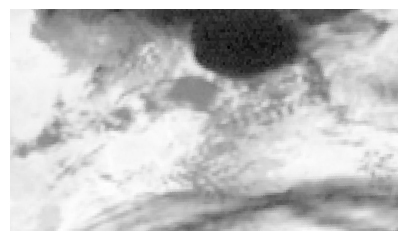

In [ ]:
show_image(img)

In [ ]:
def encode_img(input_img):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    if len(input_img.shape)<4:
        input_img = input_img.unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(input_img*2 - 1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

In [ ]:
from PIL import Image

def decode_img(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach()
    return image

In [ ]:
img.shape

torch.Size([3, 446, 780])

In [ ]:
latent = encode_img(img)

In [ ]:
latent.shape

torch.Size([1, 4, 55, 97])

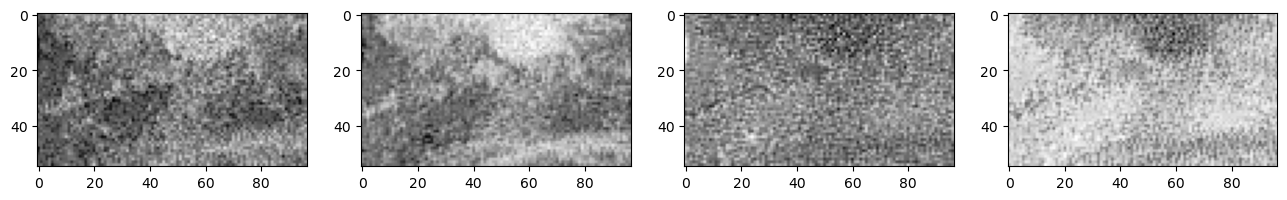

In [ ]:
# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(latent[0][c].cpu(), cmap='Greys')

In [ ]:
decoded_img = decode_img(latent)[0]

In [ ]:
img.shape, img.dtype, decoded_img.shape, decoded_img.dtype

(torch.Size([3, 446, 780]),
 torch.float32,
 torch.Size([3, 440, 776]),
 torch.float32)

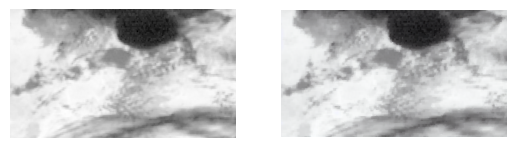

In [ ]:
show_images([img.squeeze(), decoded_img])

In [ ]:
describe(img), describe(decoded_img)

Image of type: <class 'torch.Tensor'>
data type:     torch.float32
shape:         torch.Size([3, 446, 780])
min:           0.0
max:           1.0

Image of type: <class 'torch.Tensor'>
data type:     torch.float32
shape:         torch.Size([3, 440, 776])
min:           0.031162351369857788
max:           1.0



(None, None)

difference:

<AxesSubplot: >

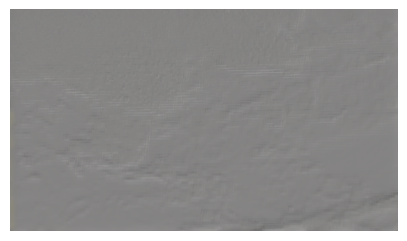

In [ ]:
show_image((img - T.Resize(img.shape[-2:])(decoded_img))+0.5)

## Log to W&B

How does the VAE from Stable diffusion works with satellite imagery!?

In [ ]:
import wandb
from fastprogress import progress_bar

In [ ]:
table = wandb.Table(columns=["input_image", "c1", "c2", "c3", "c4", "decoded_image"])

for img in progress_bar(rgb_data[0:4]):
    row = [wandb.Image(img)]
    latent = encode_img(img)
    row += [wandb.Image(c_img) for c_img in latent.squeeze()]
    decoded_img = decode_img(latent)[0]
    row += [wandb.Image(decoded_img)]
    table.add_data(*row)

In [ ]:
with wandb.init(project="ddpm_clouds", job_type="vae"):
    wandb.log({"vae_latents":table})

wandb: Currently logged in as: capecape. Use `wandb login --relogin` to force relogin
